In [1]:
%load_ext autotime
# %unload_ext autotime

In [2]:
## Import required modules:
import pandas as pd
import numpy as np    
import matplotlib.pyplot as plt
import re

from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from collections import Counter

time: 33.2 s


## Data Post-processing:

### Import reviews file (i.e. pre-processed amazon-book-reviews created by `reviews_preprocessing.ipynb` ):

In [4]:
## Load several rows of data and see what we've got
col_names = ['productID', 'title', 'price', 'userID', 'profileName', 
             'helpfulness', 'score', 'time', 'summary', 'text']
books_amazon = pd.read_csv('E://MRP//0102/Books.csv', nrows = 10, encoding = 'utf-8', names=col_names)
books_amazon.head()

,productID,title,price,userID,profileName,helpfulness,score,time,summary,text
0,1882931173,Its Only Art If Its Well Hung!,unknown,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a co...
1,826414346,Dr. Seuss,unknown,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after rea...
2,826414346,Dr. Seuss,unknown,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""..."
3,826414346,Dr. Seuss,unknown,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;..."
4,826414346,Dr. Seuss,unknown,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss


time: 31.3 ms


In [5]:
## Get all the book-names from Amaozn-data (later this list will be used to find crime-mystery books):
book_names = {}
with open ('E://MRP//0102//Books.csv') as books:
    for line in books:
        book = line.split(',')[1]
        if book not in book_names.keys():
            book_names[book] = True
        

## Total unique books: 752526
len(book_names.keys())

752526

time: 3min 17s


## Clean the book-names:

In [6]:
unique_books = list(book_names.keys())
unique_books = [book.strip().lower() for book in unique_books]
unique_books.sort()

time: 1.28 s


### Import goodreads file (i.e. data collected from `goodreads_data.ipynb`):

In [7]:
books_goodreads = pd.read_csv('E://MRP//0331//Book-Recommender-System//data//books_df.csv', encoding = 'latin1')

books_goodreads['Books'] = [book.strip().lower() for book in books_goodreads['Books']]
books_goodreads['Total_Num_Ratings'] = [int(rating.replace(',','')) for rating in books_goodreads['Total_Num_Ratings']]
books_goodreads['Total_Num_Votes'] = [int(vote.replace(',','')) for vote in books_goodreads['Total_Num_Votes']]
books_goodreads['Avg_Rating'] = [float(rating.strip("['']")) for rating in books_goodreads['Avg_Rating']]

print (books_goodreads.shape)
books_goodreads.head()

(5000, 4)


,Avg_Rating,Books,Total_Num_Ratings,Total_Num_Votes
0,4.12,"the girl with the dragon tattoo (millennium, #1)",2028253,2818
1,4.24,and then there were none,500620,2077
2,3.86,"angels & demons (robert langdon, #1)",2166178,1334
3,4.21,rebecca,342140,939
4,4.05,in cold blood,416759,765


time: 2.98 s


### Found matches for 1200 books out of 5000:

In [8]:
common_books = list(set(unique_books) & set(books_goodreads['Books']))
print (len(common_books))
common_books[0:10]

1200


['while my pretty one sleeps',
 'fight club',
 'galveston',
 'lucky',
 'cause for alarm',
 'dangerous girls',
 'no time to die',
 "boy's life",
 'shadow counter',
 'calling']

time: 381 ms


### Start building a recommendation system:

In [9]:
common_book_dict = dict()
for i in common_books:
    common_book_dict[i] = True
    
len(common_book_dict.keys())

1200

time: 6.99 ms


In [10]:
# Efficient but incomplete method!
# temp_book = ['Dr. Seuss', 'Its Only Art If Its Well Hung!']
# temp_book = [b.lower() for b in temp_book]
# temp_books = set(common_books)

list_df = []
problematic_lines = []

rows = 0
with open ('E://MRP//0102//Books.csv') as books:
    while rows < 1000000:
#     for l in books:        
        line = books.readline()

        try:
            book = line.split(', ')[1].lower().strip()

            if book in common_book_dict.keys():
                list_df.append(line)
        except:
            problematic_lines.append(line)
        rows+=1
        
len(list_df)

50229

time: 11.6 s


In [11]:
## Get ratings
ratings = [float(re.search(pattern = ' [0-5][.]0',  string = i).group()) for i in list_df]

## Get book IDs and names
book_ids = [i[0:11] for i in list_df]
print ('Book-ids: ', book_ids[0:5])

## Get book-names
book_titles = [i.split(', ')[1] for i in list_df]
print ('Book titles: ', book_titles[0:5])

## Get user-ids
user_ids = [i.split(', ')[3][0:14] for i in list_df]
print ('User-ids: ', user_ids[0:5])

Book-ids:  [' B000OX8HJO', ' 1563331586', ' B000N1ZWS6', ' 0451210530', ' 0451210530']
Book titles:  ['Trust No One', 'Chains', 'A Study in Scarlet and The Sign of Four', 'A Rip in Heaven', 'A Rip in Heaven']
User-ids:  ['A3KKFG3TA9IO8X', 'A3EX36SNRYD5VL', 'A3MV1KKHX51FYT', 'A1IMO4Q54CHVH5', 'A24VKWUKXWBWLV']
time: 704 ms


In [12]:
books_amazon_whole = pd.DataFrame({'BookID': book_ids, 'BookTitle': book_titles, 'UserID': user_ids, 'Score': ratings})
books_amazon_whole = books_amazon_whole[books_amazon_whole['UserID'] != 'unknown']
books_amazon_whole = books_amazon_whole[~books_amazon_whole['UserID'].str.contains('[0-9]+[.][0-9]+')]

print (books_amazon_whole.shape)
books_amazon_whole.head()

(39311, 4)


,BookID,BookTitle,Score,UserID
0,B000OX8HJO,Trust No One,5.0,A3KKFG3TA9IO8X
1,1563331586,Chains,3.0,A3EX36SNRYD5VL
2,B000N1ZWS6,A Study in Scarlet and The Sign of Four,5.0,A3MV1KKHX51FYT
3,0451210530,A Rip in Heaven,4.0,A1IMO4Q54CHVH5
4,0451210530,A Rip in Heaven,3.0,A24VKWUKXWBWLV


time: 310 ms


In [58]:
#### Method-1:

## Load only required columns to avoid memory-issues:
### We only need four columns: productID, title, userID, and rating. Rename them as : BookID, BookTitle, UserID, and score
# books_amazon_whole = pd.read_csv('E://MRP//0102//Books.csv', encoding = 'utf-8', header=None, usecols=[0,1,3,6])

# books_amazon_whole = pd.read_csv('E:/MRP/0102/Books.csv', header=None, usecols=[0,1,3,6], nrows = 30000)
# new_cols = ['BookID', 'BookTitle', 'UserID', 'Score']
# books_amazon_whole.columns = new_cols
# books_amazon_whole['BookTitle'] = [title.strip().lower() for title in books_amazon_whole['BookTitle']]

# print (books_amazon_whole.shape)
# books_amazon_whole.head()

In [13]:
## Unique users: there are some issues with BookId - BookTitles. #unique book-ids = 316 and #unique book-titles = 259.
## I'll use unique book-titles for better interpretation
print ('Unique user ids: ', len(set(books_amazon_whole['UserID'])))
print ('Unique books: ', len(set(books_amazon_whole['BookTitle'])))

Unique user ids:  21532
Unique books:  258
time: 17 ms


In [14]:
## Count ratings and plot
Counter(books_amazon_whole['Score'])

Counter({1.0: 1505, 2.0: 1515, 3.0: 3324, 4.0: 8682, 5.0: 24285})

time: 154 ms


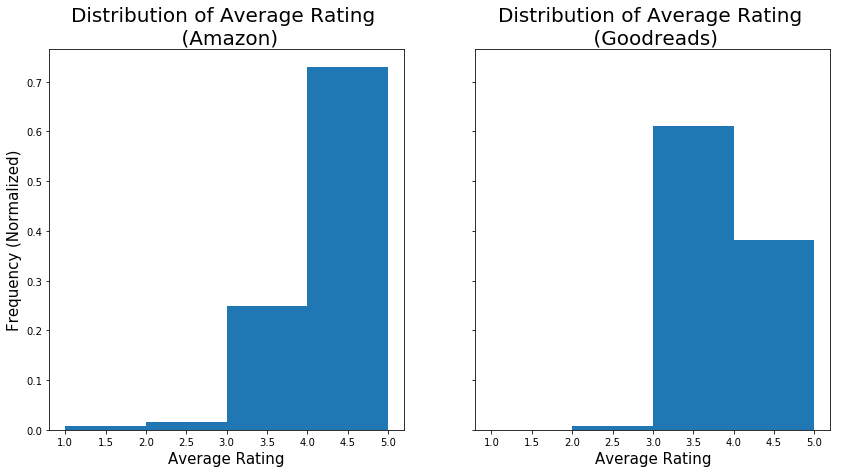

time: 1.63 s


In [15]:
amazon_rating = pd.DataFrame(books_amazon_whole.groupby(by = 'BookTitle').mean()).reset_index(drop = False)

fig, (ax1, ax2) = plt.subplots(figsize= (14,7), ncols = 2, sharey = True)
ax1.hist(amazon_rating['Score'], bins = [1,2,3,4,5], normed = True)
ax1.set_xlabel('Average Rating', fontsize = 15)
ax1.set_ylabel('Frequency (Normalized)', fontsize = 15)
ax1.set_title('Distribution of Average Rating \n (Amazon)', fontsize = 20)

ax2.hist(books_goodreads['Avg_Rating'], bins = [1,2,3,4,5], normed = True)
ax2.set_xlabel('Average Rating', fontsize = 15)
ax2.set_title('Distribution of Average Rating \n (Goodreads)', fontsize = 20)

plt.show()

In [21]:
"""
Consider users who rated >1 books. 
Two reasons: 1) Expect to get better results; 2) Speeds-up calculation and easy to manage.

# filter_users = filter_users.loc[filter_users['count'] > 1]
# filter_users.reset_index(drop = False, inplace = True)
# filter_users = books_amazon_whole.loc[books_amazon_whole['UserID'].isin(filter_users['UserID'])]
# filter_users = pd.DataFrame(books_amazon_whole.groupby(by = 'UserID').size(), columns = ['count'])
"""

In [16]:
# books_amazon_whole.drop_duplicates(subset = ['BookTitle', 'UserID'], inplace = True)
user_item_df = pd.pivot_table(data = books_amazon_whole, index = 'UserID', columns = 'BookTitle', values = 'Score')

## Fill NAs with 0 and get the new list of book-titles:
user_item_df.fillna(0, inplace=True)

print ('Shape: ', user_item_df.shape)
user_item_df.head()

Shape:  (21532, 258)


BookTitle,13 For Luck,A Clockwork Orange,A Coffin for Dimitrios,A Midsummer Night's Dream,A Rip in Heaven,A Rogue's Life,A Study in Scarlet and The Sign of Four,A Tree Grows in Brooklyn,A scandal in Bohemia,Adam,...,Trust No One,Twisted,Two for Texas,Uncle Silas,Up Country,Waterland,We Have Always Lived in the Castle,Whiteout,Wired,the Picture of Dorian Gray
UserID,,,,,,,,,,,,,,,,,,,,,
A00540411RKGTD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00878773S2MNB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01487226AT9QN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A02052513V2AZP,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A02660181QI9HH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


time: 676 ms


In [17]:
## List of books
new_book_names = user_item_df.columns

## List of users
true_user_id = list(enumerate(user_item_df.index))

print (new_book_names[0:5])
print (true_user_id[0:5])

Index(['13 For Luck', 'A Clockwork Orange', 'A Coffin for Dimitrios',
       'A Midsummer Night's Dream', 'A Rip in Heaven'],
      dtype='object', name='BookTitle')
[(0, 'A00540411RKGTD'), (1, 'A00878773S2MNB'), (2, 'A01487226AT9QN'), (3, 'A02052513V2AZP'), (4, 'A02660181QI9HH')]
time: 9 ms


### In practise, the user-item matrices are very sparse. Following two plots help in understanding the sparsity of the data in this case.

### Ratings per user (i.e. number of books rated by a user) is very less. Most users rated only 1 book. So, user-user model may not result in a good recommendation system.

In [18]:
user_data = [np.count_nonzero(user_item_df.iloc[i,:]) for i in range(user_item_df.shape[0])]
book_data = [np.count_nonzero(user_item_df.iloc[:,i]) for i in range(user_item_df.shape[1])]

time: 4.06 s


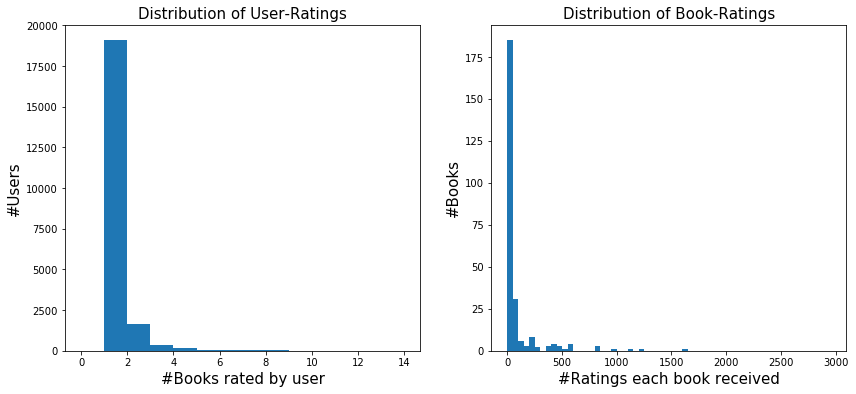

time: 791 ms


In [19]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (14,6))
ax1.hist(user_data, bins = range(0,15,1))
ax2.hist(book_data, bins = range(0, 3000,50))

ax1.set_title('Distribution of User-Ratings', fontsize = 15)
ax2.set_title('Distribution of Book-Ratings', fontsize = 15)

ax1.set_xlabel('#Books rated by user', fontsize = 15)
ax2.set_xlabel('#Ratings each book received', fontsize = 15)

ax1.set_ylabel('#Users', fontsize = 15)
ax2.set_ylabel('#Books', fontsize = 15)

plt.show()

### Item-by-item Collaborative Filtering:

In [32]:
## Train-test split
## Get #books rated by each user

def generate_train_test_data(books_ratings, user_item_mat):
    """
    Generate train/test set. In the training data, consider users who rated more than 2 books. And only those who rated more 
    than two books will only be a part of test-set because we'll predict the ratings for those additional books that they rated.
    Whenever users rated >2 books, I randomly choose one of those ratings to be a part of test-data (which eventually be 
    predicted and be used to calculate error) and make specifically that rating '0' in the train-set.
    """
    
    count_ratings_per_user = Counter(books_ratings['UserID'])

    ## list of users who rated more than 2 books
    more_than_2 = [i[0] for i in count_ratings_per_user.items() if i[1] > 2]

    test = np.zeros((len(more_than_2), user_item_mat.shape[1]))

    for i,j in enumerate(more_than_2):
        temp = books_ratings[books_ratings['UserID'] == j].groupby(by = 'UserID').agg(np.random.choice)

        ## Populate test-matrix
        ### Get column-index and rating to populate in test-data
        col_id = user_item_mat.columns.get_loc(temp.iloc[0,1])
        test[i, col_id] = temp.iloc[0,2]

        ## Make this particular pair of user-boook rating 0 in train-data
        user_item_mat.iloc[(user_item_mat.index == j), col_id] = 0
        
    return user_item_mat, test

user_item_df, test = generate_train_test_data(books_ratings = books_amazon_whole, user_item_mat = user_item_df)

time: 56.3 s


In [33]:
def calculate_similarity(user_item_ratings, e = 1e-5):
    """
    Train model to get similarity-matrix
    """
    
    sim_mat = user_item_ratings.T.dot(user_item_ratings) + e
    norms = np.array([np.sqrt(np.diagonal(sim_mat))])
        
    return (sim_mat/norms/norms.T)

sim_mat = calculate_similarity(user_item_ratings = np.matrix(user_item_df))

time: 292 ms


In [34]:
def predict_ratings_train(user_item_ratings, similarity_mat):
    """
    Predict ratings on training-data
    """
    
    pred_ratings = user_item_ratings.dot(similarity_mat) / np.reshape(np.abs(similarity_mat).sum(axis = 1), (-1))
    
    return pred_ratings

pred_ratings = predict_ratings_train(user_item_ratings = np.matrix(user_item_df), similarity_mat = sim_mat)

time: 288 ms


In [35]:
## Testing on test data
def predict_ratings_test(test_data, similarity_mat):
    """
    Preedict ratings on testing-data
    """
    
    pred_test = test_data.dot(similarity_mat)/np.reshape(np.abs(similarity_mat).sum(axis = 1), (-1))    
    
    return pred_test

pred_test = predict_ratings_test(test_data = test, similarity_mat = sim_mat)
pred_test.shape

(3579, 258)

time: 44 ms


In [36]:
def calculate_error(test_data, pred_data):
    """
    Returns Root-Mean-Squared-Error (RMSE) for ratings predicted on test-set
    """

    rmse = []
    for i in range(test_data.shape[0]): 
        non_zero_ind = np.nonzero(test_data[i,:])
        error = np.sqrt(np.sum((test_data[i, non_zero_ind] - np.array(pred_data[i, non_zero_ind])[0])**2))
        rmse.append(error)

    print ('Average RMSE: ')
    
    return round(np.mean(rmse), 2)

calculate_error(test_data = test, pred_data = pred_test)

Average RMSE: 


2.4900000000000002

time: 218 ms


In [38]:
## Make recommendations: can access actual user-ids from 'more_than_2' list using index from 'test'
# print (user_item_df.columns[np.argsort(test[user_number,:])[::-1][0:3]])

def get_recommendations(user_index, pred_matrix, books, n_recs = 10):
    """
    Generate recommendations
    """
    
    recs_id = np.argsort(pred_matrix[user_index,:].tolist()[0])[::-1][0:n_recs]
    recs = [books[i] for i in recs_id]    
    print ('For user-{}, recommendations are: \n'.format(user_index))
    
    return recs


user_number = 10
get_recommendations(user_index = user_number, pred_matrix = pred_test, books = new_book_names, n_recs = 10)

For user-10, recommendations are: 



['Tell No One',
 'Mother of Pearl',
 'Just One Look',
 'The Up and Comer',
 'The Pledge',
 'Fear Itself ',
 'Pursuit',
 'Black Cross',
 'Cops and Robbers',
 'The Last Juror']

time: 16 ms


In [ ]:
## Testing new user
# new_user_1 = np.zeros((1, user_item_df.shape[1]))
# new_user_1[0, 1] = 5
# pred_user_1 = new_user_1.dot(sim_mat)/np.reshape(np.abs(sim_mat).sum(axis = 1), (-1))

### Matrix-Factorization Approach

### Splitting data into train / test set and evaluating performance

In [41]:
import random
from sklearn.decomposition import TruncatedSVD

time: 5.32 s


In [202]:
# random.seed(11)

# user_ids_all = list(user_item_df.index)

# train_ind = random.sample(k = 50000, population = range(58991))
# train_user_ids = [user_ids_all[i] for i in train_ind]
# train_data = csr_matrix(user_item_df.iloc[train_ind, :])

# test_user_ids = [user_ids_all[j] for j in range(len(user_ids_all)) if j not in train_ind]
# test_data = csr_matrix(user_item_df.loc[test_user_ids, :])

# print ('Shape of training data: ', train_data.shape)
# print ('Shape of testing data: ', test_data.shape)

Shape of training data:  (50000, 1128)
Shape of testing data:  (8991, 1128)


### Sklearn implementation of SVD:

In [39]:
def fit_svd(train, n_compo = 10, random_state = 11):
    
    tsvd = TruncatedSVD(n_components = n_compo, random_state = random_state)
    tsvd.fit(train)
    
    return tsvd

def predict_train(tsvd_obj, train):
    
    train_predictions = np.dot(tsvd_obj.transform(train), tsvd_obj.components_)
    
    return train_predictions

def predict_test(tsvd_obj, test):
    
    test_predictions = np.dot(tsvd_obj.transform(test), tsvd_obj.components_)
        
    return test_predictions

time: 14 ms


In [42]:
# tsvd = fit_svd(train = train_data, n_compo = 25)
# predict_ratings_train = predict_train(tsvd_obj = tsvd, train = train_data)

tsvd = fit_svd(train = user_item_df, n_compo = 25)
predict_ratings_train = predict_train(tsvd_obj = tsvd, train = user_item_df)

predict_ratings_train.shape

(21532, 258)

time: 1.32 s


In [44]:
predict_ratings_test = predict_test(tsvd_obj = tsvd, test = test)
predict_ratings_test.shape

(3579, 258)

time: 23 ms


In [45]:
def plot_rmse(rmse_list, n_users = 500):
    
    fig, ax = plt.subplots(figsize = (14,8))
    ax.plot(rmse_list[0:n_users])
    ax.axhline(y = np.mean(rmse_list), label = 'Avg. RMSE: {}'.format(round(np.mean(rmse_list), 3)), 
               color = 'r', linestyle = 'dashed')
    ax.set_ylabel('RMSE', fontsize = 15)
    ax.set_xlabel('UserId', fontsize = 15)
    ax.set_title('RMSE for each user', fontsize = 20)
    ax.legend()
    plt.show()    
    
    return None

time: 11 ms


In [75]:
rmse_train = np.sqrt(np.mean(np.array((np.matrix(user_item_df) - predict_ratings_train))**2, axis = 1))

time: 238 ms


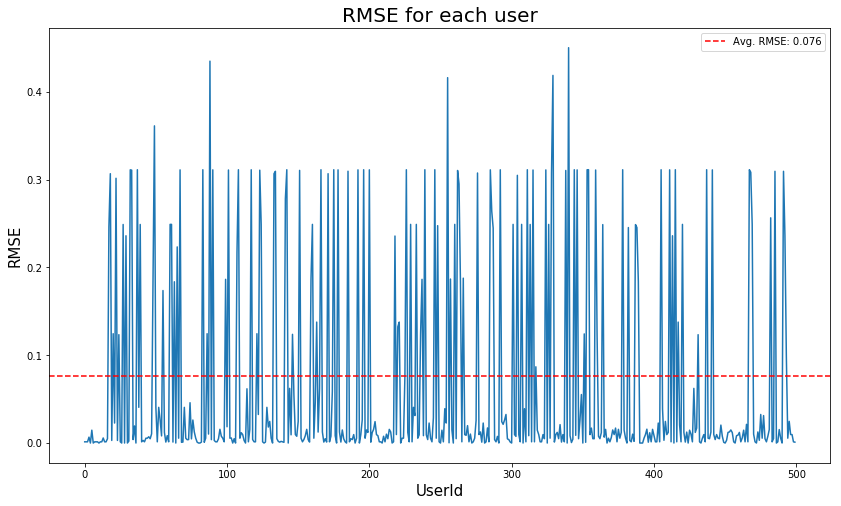

time: 521 ms


In [77]:
plot_rmse(rmse_train)

In [209]:
def get_recommended_books(user_id, books_list, latent_ratings, ui_mat, top_n = 15):
    
    ## Get recommendations for a given user:
    ind_top_rated_books = np.argsort(latent_ratings.iloc[user_id])[::-1][0:top_n]
    recommended_books = [books_list[ind] for ind in ind_top_rated_books]    
    recommendation_df = pd.DataFrame({'UserID': user_id, 'BookID': ind_top_rated_books, 
                                     'Recommended_Books': recommended_books})
    
    ## Get actual books that the user rated:
    user_rated_books = ui_mat[user_id,:].toarray()
    rated_books_ind = np.argwhere(user_rated_books != 0)[:,1]
    rated_books = [books_list[ind] for ind in rated_books_ind]
    user_rated_books_df = pd.DataFrame({'BookID': rated_books_ind, 'RatedBooks': rated_books, 'UserID': user_id})
    
    return user_rated_books_df, recommendation_df

## Try: 211
user_rated_books, recommended_books = get_recommended_books(user_id = 211, books_list = new_book_names, 
                                      latent_ratings = predict_ratings, ui_mat = user_item_mat)

In [216]:
rated_books, recommended_books = get_recommended_books(user_id = 100, books_list = new_book_names, 
                                      latent_ratings = pd.DataFrame(predict_ratings_train), ui_mat = train_data)

In [217]:
rated_books

,BookID,RatedBooks,UserID
0,937,the poisonwood bible,100


In [218]:
recommended_books

,UserID,BookID,Recommended_Books
1127,100,937,the poisonwood bible
1126,100,699,the blind assassin
1125,100,641,snow falling on cedars
1124,100,642,snow flower and the secret fan
1123,100,1092,under the tuscan sun
1122,100,934,the pilot's wife
1121,100,1006,the testament
1120,100,548,possession
1119,100,452,midnight in the garden of good and evil
1118,100,792,the emperor of ocean park


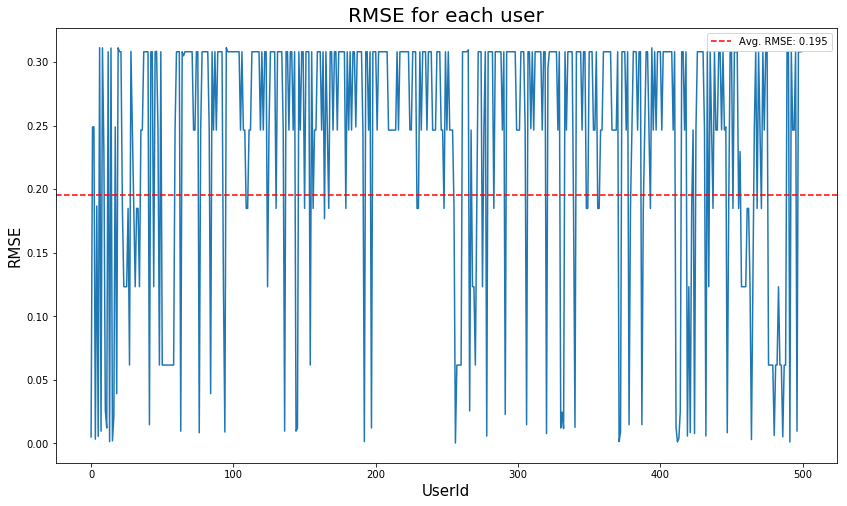

time: 489 ms


In [78]:
# rmse_test = np.sqrt(np.mean((test_data.toarray() - predict_ratings_test)**2, axis = 1)) 
rmse_test = np.sqrt(np.mean(np.array((np.matrix(test) - predict_ratings_test))**2, axis = 1))
plot_rmse(rmse_test)

## Notes:

1. Increasing **#singual values** decreases RMSE. This also increases the overlap between the recommended books and the books that a user has already rated.

2. Currently, not using actual **BookID** and **UserID**, but they can easily be traced back (example given).

3. Sparsity of the user-item-matrix is still an issue.

4. Only considering users who rated **at least two** books.

5. As most of the predicted ratings are close to 0 and most of the actual ratings are also 0 (i.e. users didn't rate a lot of books), we eventually end-up with lower RMSE. In other words, sparsity (i.e. a lot of 0s)decreases RMSE. If we were to have dense matrix then, probably, RMSE will be a bit higher than current value.